CURRENT ALGORITHM:

The algorithm extracts facts (locations,dates,reporting terms, reporting units, and quantities) on a sentence by sentence basis, while using a working memory to store the most recently extracted set of locations and dates.

Dates and locations are identified within each sentence if present. The most recently seen dates and locations are remembered, for use in sentences where they are absent but the other reporting elements are present.

The algorithm relies on lists of (a) reporting terms and (b) reporting units. These two lists are each subdivided into structure and person related tokens, giving a total of four lists. When extracting facts from a sentence, the algorithm checks each token within the sentence to see if it falls within one of these four lists. A token that falls within one of these lists is known as a root_node.

The algorithm then attempts to find a suitable partner for this root_node. In order to ensure that tokens and units are appropriately matched (eg to prevent the creation of reports of houses being murdered), the type of the unit or term (ie person or structure) comprising the root_node is taken into account.

The branch search algorithm accepts a root node and an appropriate list of partner tokens (determined by the term/unit person/structure nature of the root node). It searches for nodes either adjacent to or below the root_node within the sentence tree. If any of these nodes meet the partner token criteria, then the algorithim declares this node to be the partner_node of the root_node and proceeds to search for a number. The algorithm assumes that numbers will either be adjacent to or below the partner_node, with tokens below the partner_node being examined before adjacent tokens. Potential numbers are checked to ensure that they are not part of a previously identified date. 

In cases where the root node is a person reporting term, but no reporting units are detected, the possibility of implicit units is considered. The algorithim will look for a numeric token adjacent to or below the root_node, and assume that the reporting unit is "person".



ISSUES:

Sentences with qualifiers between reporting terms and units can fail to produce reports eg "Six people, including women and children, were reported as killed in the floods.". We could solve this problem by creating a list of linkage words. If the head of the root_node is found to be such a word, the algorithm would begin its search for the partner_node at the linkage word token.

Sentences with a "reporting phrase" rather than a reporting term, eg "The report reads that the rains of March 28 and 29 left 2,160 people from Sumbe and Porto Amboim in a situation of dire need, as one was killed, three wounded and 150 houses destroyed, laving 483 homeless" (with the reporting phrase in a situation of dire need) can be very problematic, since the algorithm fails to detect the appropriate reporting term, and potentially inappropriately links the reporting unit to another reporting term in the sentence (in this case it reports 2160 people killed).

In [355]:
import pandas as pd
import spacy
import os
import sys
from nltk import Tree
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from internal_displacement.pipeline import SQLArticleInterface

In [356]:
nlp = spacy.load('en')

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [357]:
pipeline = SQLArticleInterface("../sql_db.sqlite") #Connecting to pre-populated database.
labels,features = pipeline.get_training_data()

In [402]:
person_reporting_terms = [
    'displaced', 'evacuated', 'forced','flee', 'homeless',
    'sheltered', 'relocated', 'stranded','stuck','stranded',"killed","dead","died"
]

structure_reporting_terms = [
    'destroyed','damaged','swept','collapsed','flooded','washed','destruction'
]

person_reporting_units = ["families","person","people","individuals","locals","villagers","residents","occupants","citizens"]

structure_reporting_units = ["home","house","hut","dwelling","building","shop",
                             "business","apartment","flat","residence","school"]


person_term_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_terms))]
structure_term_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_terms))]
person_unit_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_units))]
structure_unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units))]

reporting_term_lemmas = person_term_lemmas + structure_term_lemmas
reporting_unit_lemmas = person_unit_lemmas + structure_unit_lemmas

In [403]:
class Report(object):
    """Contains reporting term, unit, quantity, date(s) and location(s)
        ----------
        locations:              identified location names:String
        date_time:              the estimated date of the event:String
        event_term:             the reporting term:String
        subject_term:           the reporting unit:String
        quantity:               the quantity of units affected:String
        story:                  the original story:String
        tokens:                 the tokens used to generate the report
        tag_spans:              the spans for visualization identified tags:List of Dicts
        
    """

    def __init__(self, locations, date_time, event_term, subject_term, quantity, story, tokens, tag_spans=[]):
        self.locations = locations
        self.date_time = date_time
        self.event_term = event_term
        self.subject_term = subject_term
        self.quantity = quantity
        self.story = story
        self.tokens = tokens
        self.tag_spans = tag_spans

    def generate_displacy_json(self):
        """
        :return:
        """
        pass

    def display(self):
        print("Location: {}  DateTime: {}  EventTerm: {}  SubjectTerm:  {}  Quantity: {}"
              .format(self.locations, self.date_time, self.event_term, self.subject_term, self.quantity))

    def __eq__(self, other):
        if isinstance(other, Report):
            return ((self.locatons == other.locations) and
                    (self.date_time == other.date_time) and
                    (self.event_term == other.event_term) and
                    (self.subject_term == other.object_term) and
                    (self.quantity == other.quantity)
                    )
        else:
            return False

    def __ne__(self, other):
            return (not self.__eq__(other))

    def __hash__(self):
            return hash(self.__repr__())
    def show_story_tree(self):
        self.display()
        for sentence in nlp(self.story).sents:
            for token in sentence:
                if token.lemma_ == self.event_term:
                    return to_nltk_tree(sentence.root)

In [404]:
def test_token_equality(token_a,token_b):
    if ((token_a.text == token_b.text) and (token_a.head == token_b.head)):
        return True
    else:
        return False
    
def check_if_collection_contains_token(token,collection):
    if any([test_token_equality(token,t) for t in collection]):
        return True
    else:
        return False
    
def get_descendents(sentence,root=None):
    """
    Retrieves all tokens that are descended from the specified root token.
    param: root: the root token
    param: sentence: a span from which to retrieve tokens.
    returns: a list of tokens
    """
    if not root:
        root = sentence.root
    return [t for t in sentence if root.is_ancestor_of(t)]

    
def check_if_entity_contains_token(tokens,entity):
    """
    Function to test if a given entity contains at least one of a list of tokens.
    param: tokens: A list of tokens
    param: entity: A span
    
    returns: Boolean
    """
    tokens_ = [t.text for t in tokens]
    ret = False
    for token in entity:
        if token.text in tokens_:
            return True
    return False

In [405]:
def get_common_ancestors(tokens):
    ancestors = [set(t.ancestors) for t in tokens]
    if len(ancestors) == 0:
        return []
    common_ancestors = ancestors[0].intersection(*ancestors)
    return common_ancestors    
def get_closest_contiguous_location_block(entity_list,root_node):
    location_entity_tokens = [[token for token in sentence] for sentence in entity_list]
    token_list =  [item for sublist in location_entity_tokens for item in sublist]
    location_tokens_by_distance = sorted([(token,get_distance_between_tokens(token,root_node)) 
                                          for token in token_list],key= lambda x: x[1])
    closest_location = location_tokens_by_distance[0]
    contiguous_block = [closest_token]
    added_tokens = 1
    while added_tokens > 0:
        contiguous_block_ancestors = [[token for token in token_list if token.is_ancestor_of(toke)] for toke in contiguous_block ]
        contiguous_block_subtrees = [token.subtree for token in contiguous_block]
        contiguous_block_neighbours = contiguous_block_ancestors + contiguous_block_subtrees
        contiguous_block_neighbours = [item for sublist in contiguous_block_neighbours for item in sublist]
        added_tokens = 0
        for toke in token_list:
            if not check_if_collection_contains_token(toke,contiguous_block):
                if toke in contiguous_block_neighbours:
                    added_tokens +=1
                    contiguous_block.append(toke)
    return contiguous_block


def get_distance_between_tokens(token_a,token_b):

    if token_b in token_a.subtree:
        distance = get_distance_from_root(token_b,token_a)
    elif token_a in token_b.subtree:
        distance = get_distance_from_root(token_a,token_b)
    else:
        common_ancestors = get_common_ancestors([token_a,token_b])
        distance = 10000
        for ca in common_ancestors:
            distance_a = get_distance_from_root(ca,token_a)
            distance_b = get_distance_from_root(ca,token_b)
            distance_ab = distance_a + distance_b
            if distance_ab < distance:
                distance = distance_ab
    return distance

def get_contiguous_tokens(token_list):
    common_ancestor_tokens = get_common_ancestors(token_list)
    highest_contiguous_block = []
    for toke in token_list:
        if check_if_collection_contains_token(toke.head,common_ancestor_tokens):
            highest_contiguous_block.append(toke)
    added_tokens = 1
    while added_tokens > 0:
        added_tokens = 0
        for toke in token_list:
            if check_if_collection_contains_token(toke.head,highest_contiguous_block):
                if not check_if_collection_contains_token(toke,highest_contiguous_block):
                    highest_contiguous_block.append(toke)
                    added_tokens +=1
    return highest_contiguous_block

def match_entities_in_block(entities,token_block):
    matched = []
    text_block = [t.text for t in token_block] #For some reason comparing identity on tokens does not always work.
    for e in entities:
        et = [t.text for t in e]
        et_in_b = [t for t in et if t in text_block]
        if len(et_in_b) == len(et):
            matched.append(e)
    return matched

In [406]:
def extract_locations(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a location.
    If a root token is specified, only location tokens below the level of this token in the tree will be examined. 
    If no root is specified, location tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    location_entities = [e for e in nlp(sentence.text).ents if e.label_ == "GPE"]
    if len(location_entities) > 0:
        descendent_location_tokens = []
        for location_ent in location_entities:
            if check_if_entity_contains_token(location_ent,descendents):
                descendent_location_tokens.extend([token for token in location_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_location_tokens)

        block_locations = match_entities_in_block(location_entities,contiguous_token_block)
        if len(block_locations) > 0:
            return [location.text for location in block_locations]
        else:
            return location_entities #When we cannot decide which one is correct, choose them all
                                    #and figure it out at the report merging stage.
    else:
        return []
def extract_dates(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a date.
    If a root token is specified, only date tokens below the level of this token in the tree will be examined. 
    If no root is specified, date tokens will be drawn from the entirety of the span.
    Unlike the extract dates function (which returns a list of strings),
    this function returns a list of spacy spans. This is because numerical quantities detected in the 
    branch_search need to be checked to ensure they are not in fact parts of a date.
    
    param: sentence       a span
    param: root           a token
    returns: A list of spacy spans
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root.head) #Searches from the head of the root for descendents
    date_entities = [e for e in nlp(sentence.text).ents if e.label_ == "DATE"]
    if len(date_entities) > 0:
        descendent_date_tokens = []
        for date_ent in date_entities:
            if check_if_entity_contains_token(date_ent,descendents):
                descendent_date_tokens.extend([token for token in date_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_date_tokens)

        block_dates = match_entities_in_block(date_entities,contiguous_token_block)
        return block_dates
    else:
        return None

    
def check_not_in_date(token,date_entities):
    """
    Checks if a token is not part of a recognised date entity. Used to prevent date tokens being extracted
    as quantities.
    :param token     a token
    :param date_tokens    the list of spacy date entities produced by extract_dates
    
    returns: boolean
    """
    if date_entities:
        for date in date_entities:
            if token in date:
                return False
    return True



def get_number_node(root_node,partner_node,dates):
    root_children = list(root_node.children)
    partner_subtree = list(partner_node.subtree)
    partner_subtree = sorted(([(x,len(list(x.subtree))) for x in partner_subtree]),key = lambda x: x[1])
    partner_subtree = [x[0] for x in partner_subtree]
    candidates = partner_subtree + root_children
    numeric_candidates = [t for t in candidates if basic_number(t) and check_not_in_date(t,dates)]
    if len(numeric_candidates) > 0:
        return numeric_candidates[0]
    else:
        return None
    
    
def basic_number(token):
    """
    Placeholder function. Will be replaced by a more complete number detection function.
    """
    if token.text == "dozens":
        return True
    if token.like_num:
        return True
    else:
        return False

1) Find a term or a unit. This is the root node.

2) Look below the term or unit for an appropriate matching unit or term, respectively. This is the partner node.

3a) Look at the immediate children of the root node. If a number is present, use it.

3b) If no number is present, use the highest positioned number from the full collection of partner node descendents.

In [407]:
def branch_search(root_node,search_target_lemmas,used_tokens,root_type,dates_memory,locations_memory,story,sentence,unit_type):
    """
    Attempts to complete a report starting from the specified root node.
    Searches down the tree for an appropriate counterpart to the term or unit specified as the root.
    If an an appropriate counterpart is found, searches for a number. Generates a report.
    If the root is a term, and no unit is found, and if the term applies to people, and if a quantity is detected,
    assumes an implicit reporting of people.
    Attempts to find dates and locations, but if none are found, 
    the working memory (if present) is used for these.
    
    
    returns: Report objects
    """

    descendents = get_descendents(sentence,root_node.head) #Actually searches for descendents of the head of the root
    relevant_descendents = [t for t in descendents if t.lemma_ in search_target_lemmas]
    permitted_descendents = [t for t in descendents if t.text not in used_tokens]
    possible_locations = extract_locations(sentence,root_node)
    possible_dates = extract_dates(sentence,root_node)
    if not possible_locations:
        possible_locations = locations_memory
    if not possible_dates:
        possible_dates = dates_memory

    reports = []

    if root_type == "TERM":
        root_span = {'start': root_node.idx, 'end': len(
                    root_node) + root_node.idx, 'type': 'TERM'}
        report_term = root_node.lemma_
        
        for report_unit in relevant_descendents:
            number = get_number_node(root_node,report_unit,possible_dates)
            if number:
                report_quantity = number.text
                numeric_span = {'start': number.idx, 'end': len(number) + number.idx, 'type': 'NUM'}
                unit_span = {'start': report_unit.idx, 'end': len(report_unit) + report_unit.idx, 'type': 'UNIT'}
                report_spans = [root_span,numeric_span,unit_span]
                report_tokens = [root_node,report_unit,number]
                report = Report(possible_locations,possible_dates,report_term,
                                report_unit.lemma_,report_quantity,story,report_tokens,report_spans)
                reports.append(report)
#                 report.display()
                break
        
        if unit_type == "PERSON": #Checking for implicits if no units are detected for a person related term.
            if len(relevant_descendents) == 0:
                number = get_number_node(root_node.head,root_node,possible_dates)
                if number:
                    report_unit = "person"
                    report_quantity = number.text
                    numeric_span = {'start': number.idx, 'end': len(number) + number.idx, 'type': 'NUM'}
                    
                    report_spans = [root_span,numeric_span]
                    report_tokens = [root_node,number]
                    report = Report(possible_locations,possible_dates,report_term,
                                    report_unit,report_quantity,story,report_tokens,report_spans)
                    reports.append(report)
#                     report.display()



    elif root_type == "UNIT":

        root_span = {'start': root_node.idx, 'end': len(
                    root_node) + root_node.idx, 'type': 'UNIT'}
        report_unit = root_node.lemma_
        for report_term in relevant_descendents:

            number = get_number_node(root_node,report_term,possible_dates)
            if number:
                report_quantity = number.text
                numeric_span = {'start': number.idx, 'end': len(number) + number.idx, 'type': 'TERM'}
                term_span = {'start': report_term.idx, 'end': len(report_term) + report_term.idx, 'type': 'UNIT'}
                report_tokens = [root_node,number,report_term]
                report_spans = [root_span,numeric_span,term_span]
                report = Report(possible_locations,possible_dates,report_term.lemma_,
                                report_unit,report_quantity,story,report_tokens,report_spans)
                reports.append(report)
#                 report.display()
            break #operating on the assumption that the first report generated 
            #(by definition with the closest set of partner and number nodes to the root)
            #will be the correct one.
    return list(set(reports))
    
def flatten_list(lists):
    return [item for sublist in lists for item in sublist]
    
    
def process_sentence(sentence,dates_memory,locations_memory,story):
    """
    Searches for a starting point to begin creating a report. 
    This can be either a reporting term or a reporting unit.
    Always searches top-down.
    """
    sentence_reports = []
    for token in sentence:
        reports = []
        used_tokens = flatten_list([report.tokens for report in sentence_reports])
        used_tokens = [t.text for t in used_tokens]
        if token.lemma_ in structure_term_lemmas:
            root_type = "TERM"
            unit_type = "STRUCTURE"
            targets = structure_unit_lemmas
            reports = branch_search(token,targets,used_tokens,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        elif token.lemma_ in structure_unit_lemmas:
            root_type = "UNIT"
            unit_type = "STRUCTURE"
            targets = structure_term_lemmas
            reports = branch_search(token,targets,used_tokens,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        elif token.lemma_ in person_term_lemmas:
            root_type = "TERM"
            unit_type = "PERSON"
            targets = person_unit_lemmas
            reports = branch_search(token,targets,used_tokens,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        elif token.lemma_ in person_unit_lemmas:
            root_type = "UNIT"
            unit_type = "PERSON"
            targets = person_term_lemmas
            reports = branch_search(token,targets,used_tokens,root_type,dates_memory,locations_memory,story,sentence,unit_type)

        sentence_reports.extend(reports)
    return list(set(sentence_reports))
        
def process_article(story):
    processed_reports = []
    if len(story) < 25: #Skip garbage reports.
        return processed_reports
    
    sentences = list(nlp(story).sents) # Split into sentences
    dates_memory = None # Keep a running track of the most recent dates found in articles
    locations_memory = None # Keep a running track of the most recent locations found in articles
    for sentence in sentences: # Process sentence
        reports = []
        reports = process_sentence(sentence,dates_memory,locations_memory, story)
        current_locations = extract_locations(sentence)
        if current_locations:
            locations_memory = current_locations
        current_dates = extract_dates(sentence)
        if current_dates:
            dates_memory = current_dates
        processed_reports.extend(reports)
    return processed_reports

In [408]:
ct = [x for x in features if "Further severe weather, floods and landslides have left 14 people dead and 4 missing in southern China" in x]
ct

['Further severe weather, floods and landslides have left 14 people dead and 4 missing in southern China.  Yesterday the Chinese government said that the storms and heavy rainfall from 18 to 22 June 2014 affected nine southern provinces. 8,700 homes have been destroyed, 66,000 homes damaged and forced 337,000 people to evacuate. 42,000 hectares of crops have also been destroyed. Further heavy rainfall is forecast for the next 24 hours.  According to Xinhua:  Seven people have died in central China’s Hunan Province, five in the eastern province of Jiangxi and two in Guangxi Zhuang Autonomous Region, south of the country. Hunan provincial civil affairs bureau confirmed that four people are missing.  Southern China has endured relentless severe weather conditions since 8 May 2014 where 3 people died after flooding in 5 southern provinces.  The flooding continued through May, resulting in a further 19 deaths. Earlier this month 25 people died after floods lasting a week hit much of souther

In [409]:
for art in features[100:200]:
    print("ARTICLE:")
    print(art)
    print("REPORTS:")
    reports = process_article(art)
    for r in reports:
        r.display()

ARTICLE:

REPORTS:
ARTICLE:
Message sent on behalf of Mr. Ignacio Leon-Garcia Head of OCHA Regional Office for Southern Africa  In Madagascar, Hellen continues to weakening, with maximum wind speeds of 55 km/h. At 09H00 local time (UTC+3) the weather system was located 250 km north-east of Morondava and is currently moving in a south-easterly direction into the Mozambique Channel. The National Bureau of Risk and Disaster Management (BNGRC) have lifted all alerts. See attached map.  A multi-sector aerial assessment of the inaccessible districts of Soalalala, Mitsinjo and Besalampy identified damaged classrooms and flooded agricultural fields. There are reportedly needs in the sector of water, sanitation and hygiene (WASH), but most healthcare centres appear intact. The Prime Minister visited Soalala today, bringing relief items including water treatment products, medicines and cash.  Initial results indicate that 919 people have been displaced, of which some will be able to return home 

In [400]:
reports[2].show_story_tree()

IndexError: list index out of range

In [ ]:
t = [f for f in features if "The information is contained in a report on the consequences of the rains," in f]

for art in t:
    print("ARTICLE:")
    print(art)
    print("REPORT:")
    reports = process_article(art)
    for r in reports:
        r.display()

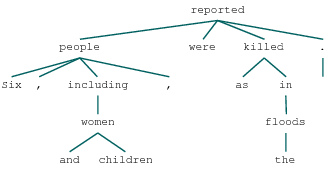

In [255]:
to_nltk_tree(list(nlp(t[0]).sents)[2].root)

Location: [Sumbe]  DateTime: [March 28]  EventTerm: kill  SubjectTerm:  people  Quantity: one


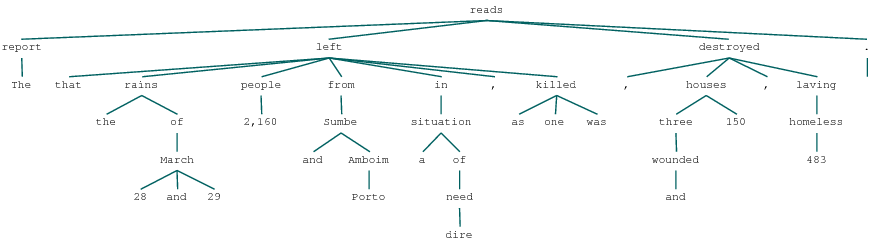

In [328]:
reports[1].show_story_tree()